Project #1 - Genetic Algorithm

CS414/515
Spring 2023
Due: Friday, February 24th

The goal of this project is to perform two simple experiments using a genetic algorithm (GA).  Start with the GA we developed in class, but make any additions or modifications that are necessary for your experiment. Possible experiments include testing the effects of changing basic parameters of the GA:



In [23]:
# install necessary packages

import pygwalker as pyg
import pandas as pd
import numpy as np
import random;import copy
import sys;import time
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

In [24]:
# set initial parameters

genomesize = 1000     # size of genome in an individual
gens = 1000             # number of generations of popuation
popsize = 1000         # popuation of individuals
DNAcharacters = 'TGCA'  # possible DNA nucleotides on genome 

The potential computational complexity for an evolutionary algorithm with the following input parameters is difficult to estimate precisely, but we can make some rough estimates:

- **Genome size (genomesize)**: The size of each genome is 1000, so the algorithm needs to manipulate a set of 1000 characters for each individual in the population.
- **Number of generations (gens)**: The algorithm will run for 1000 generations, so it will perform the evolution process for 100 times.
- **Population size (popsize)**: The population size is 1000, so the algorithm will have the opportunity to manipulate 10000 individuals in each gen.

The main computational complexity of the evolutionary algorithm is dirived from evaluation of  fitness & diversity functions for every ind in the popul which is likely have a linear complexity with respect to the genome size

The selection and reproduction processes have some complexity, mainly due to fitness sorting with complexity: $$O(n log n)$$,  (n = pop size) 

Potentially, complexity of this evolutionary algorithm is at least O(genomesize * gens * popsize * log popsize), 

which is quite high, since it grows linearly with the genome size, the number of generations, and the population size, and logarithmically with the population size. 

However, this is just a rough estimate, and the actual computational complexity will depend on the specific implementation and the details of the fitness and diversity functions.





In [25]:
# construct empty lists for data collections

times = []
sizes = []
ave_scores = []
max_scores = []
max_iterations = []
ave_mutations = []
max_mutations = []
ave_diversity = []
max_diversity = []

The **crossover_rate** function is used to determine the rate of crossover for use in  this evolutionary simulation. 

This rate is a parameter that determines the probability that two parent solutions will exchange genetic information.

Steps:
1.	generates a random float value between 0 and 9 using the Python base "random" module.
2.	The function uses a seed value to guarantee replication with the same random number sequence is produced over each iteration.
3.  The generated float value is then returned from of the function.


---
**calculate_diversity** the function calculates the diversity of a genome based on the frequency of each character.


1. Create an empty dictionary counts to store the counts of each character in the genome.

2. Iterate through each character in the genome, and add 1 to the count of the character in the counts dictionary. If the character is not already in the dictionary, set its count to 1.

3. Calculate the frequency of each character by dividing its count by the total length of the genome (n).

4. Calculate the diversity score by iterating through each frequency, calculating the product of the frequency and its complement (1 - frequency), and summing up the results.

5. Return the diversity score.


a diversity score of 1 would mean that the genome contains an equal number of all possible characters- perfectly diverse). 

In [26]:
# global helper functions

# determines parent crossover rate, experimental I
def crossover_rate():
        random.seed(17)
        crossover_rate = random.uniform(0,9)
        return crossover_rate

# determines mutation rate for genome, experimental I
def mutation_rate():
        mutation_base = random.uniform(2,4)
        var = random.gauss(0.1, 0.05)
        mutation_rate = mutation_base * var
        return mutation_rate
    

In [27]:
class individual:
    def __init__(self):
        self.fitness = 0
        self.diversity = 0
        self.genome = []
        for i in range(0,genomesize):
            self.genome.append(random.choice(DNAcharacters))
        self.calcFitness2()
        self.calcDiversity()

    def print(self):
        for c in self.genome:
            print(c,end = "")
        print("  fitness:" + str(self.fitness))
    
    def calcFitness2(self):
        self.fitness = 0
        for i in range(len(self.genome)-1):
            if i + 1 < len(self.genome) and self.genome[i] == 'C' and self.genome[i+1] == 'G':
                self.fitness += 1
        return self.fitness/popsize

    #   determines diversity by calculating distribution of nucleotides, based on the frequency of each character
    #  [range 0-1, with 1 being total equality of nucleotides in genome ]
    def calcDiversity(self):
        self.diversity = 0
        counts = {}
        for letter in self.genome:
            counts[letter] = counts.get(letter, 0) + 1
        freqs = [count/genomesize for count in counts.values()]
        self.diversity = sum([(f*(1-f)) for f in freqs])
        #print(self.diversity)
        return self.diversity
    
    def mutation(self,mutation_rate):
        for i in range(0,genomesize):
            if(random.uniform(0,100) < mutation_rate):
                self.genome[i] = random.choice(DNAcharacters)
                #mutations.append(mutation_rate)
        self.calcFitness2()
        self.calcDiversity()

    def copy(self,source):
        self.fitness = source.fitness
        self.diversity = source.diversity
        for i in range(0,genomesize):
            self.genome[i] = source.genome[i]

In [28]:
class population:
    def __init__(self):  
        self.avg_fitness = 0
        self.avg_diversity = 0
        self.the_pop = []
        for i in range(0,popsize):
            self.the_pop.append(individual())

    def calcstats(self):
        self.avg_fitness = 0
        for i in self.the_pop:
            self.avg_fitness += i.fitness
        self.avg_fitness /= popsize
        
    def calcstats2(self):
        self.avg_diversity = 0
        for i in self.the_pop:
            self.avg_diversity += i.diversity
        self.avg_diversity /= popsize
          
        
    def generationalElite1(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            self.the_pop.sort(key=lambda x: x.fitness, reverse=True)
            parent1 = 0 
            parent2 = 1
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.onepoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        
    def generationalElite2(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            self.the_pop.sort(key=lambda x: x.fitness, reverse=True)
            parent1 = 0 
            parent2 = 1
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.twopoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        
    def generationalEliteU(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            self.the_pop.sort(key=lambda x: x.fitness, reverse=True)
            parent1 = 0 
            parent2 = 1
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.uniform_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        
    def generational_tournU(self,mutation_rate):  # tournament + uniform crossover
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.tournament()
            parent2 = self.tournament()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.uniform_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        
    def generational_tourn1(self,mutation_rate): # tournament + onepoint crossover
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.tournament()
            parent2 = self.tournament()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.onepoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        
        
    def generational_tourn2(self,mutation_rate): # tournament + twopoint crossover
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.tournament()
            parent2 = self.tournament()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.twopoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()

    def generational_rouletteU(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.roulette()
            parent2 = self.roulette()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.uniform_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        
    def generational_roulette1(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.roulette()
            parent2 = self.roulette()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.onepoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        
        
    def generational_roulette2(self,mutation_rate):
        tempPop = population()
        for i in range(0,popsize,2):
            parent1 = self.roulette()
            parent2 = self.roulette()  
            tempPop.the_pop[i].copy(self.the_pop[parent1])
            tempPop.the_pop[i+1].copy(self.the_pop[parent2])
            tempPop.twopoint_crossover(i,i+1)
            tempPop.the_pop[i].mutation(mutation_rate)
            tempPop.the_pop[i+1].mutation(mutation_rate)
        for i in range(0,popsize):
            self.the_pop[i].copy(tempPop.the_pop[i])
        self.calcstats()
        self.calcstats2()
        
# selection methods ************************************        
        
    def tournament(self):
        tourn_size = 2
        best_so_far = random.randint(0,popsize-1)
        best_fitness = self.the_pop[best_so_far].fitness
        for i in range(0,tourn_size - 1):
            current = random.randint(0,popsize-1)
            current_fit = self.the_pop[current].fitness
            if(current_fit > best_fitness):
                best_so_far = current
                best_fitness = current_fit
        return best_so_far
    
    
    def roulette(self):  #fitness proportionate selection with default to elite or uniform
        self.the_pop.sort(key=lambda x: x.fitness, reverse=True)
        fit_values = [individual.fitness for individual in self.the_pop]
        #print(fit_values)
        max_fit = max(fit_values)
        sum_fit = sum(fit_values)
        probs = [fit/sum_fit for fit in fit_values]
        U = random.uniform(0, 1)
        C = 0
        for i, prob in enumerate(probs):
            C += prob
            if C > U:
                return i

# elite is built directly into main call generationElite* up
    
# crossover methods **************************************    
    
    def uniform_crossover(self,p1,p2):
        crossover_rate = random.uniform(0,9)
        for j in range(0,genomesize):
            if random.randint(0,100) < crossover_rate:
                temp = self.the_pop[p1].genome[j]
                self.the_pop[p1].genome[j] = self.the_pop[p2].genome[j]
                self.the_pop[p2].genome[j] = temp
    
    def onepoint_crossover(self,p1,p2):
        crossover_point = random.randint(0,genomesize)
        for j in range(crossover_point, genomesize):
            temp = self.the_pop[p1].genome[j]
            self.the_pop[p1].genome[j] = self.the_pop[p2].genome[j]
            self.the_pop[p2].genome[j] = temp
    
    def twopoint_crossover(self,p1,p2):
        position1 = random.randint(0,genomesize)
        position2 = random.randint(0,genomesize)
        for j in range(position1, position2):
            temp = self.the_pop[p1].genome[j]
            self.the_pop[p1].genome[j] = self.the_pop[p2].genome[j]
            self.the_pop[p2].genome[j] = temp

In [29]:
mutations1 = []
g1=[]
ind=[]
p = population()
d1 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations1.append(mutate*10)
    ind.append(i)
    p.generational_rouletteU(mutate)
    d1.append(p.avg_diversity)
    g1.append(p.avg_fitness) 
end_time = time.time()
#****************************************

times.append(end_time - start_time)
sizes.append(sys.getsizeof(g1))
max_scores.append(max(g1))
max_iterations.append(g1.index(max(g1)))
ave_scores.append(np.mean(g1))
ave_diversity.append(np.mean(d1))
ave_mutations.append(np.mean(mutations1))
max_mutations.append(max(mutations1))

print("Mutation max:",np.round(max(mutations1)))
print("Mutation average:",np.round(np.mean(mutations1)))

print("Max Fitness Score for Roulette w/ Uniform Crossover: ",max(g1))
print("Average Diversity Score for Roulette w/ Uniform Crossover: ",np.mean(d1))

print("Time elapsed: ", np.round(end_time - start_time))
print("g1 size in bytes: ", sys.getsizeof(g1))
print("Maximum score was attained at iteration: ", g1.index(max(g1)))

best1 = g1.index(max(g1))

Mutation max: 9.0
Mutation average: 3.0
Max Fitness Score for Roulette w/ Uniform Crossover:  139.451
Average Diversity Score for Roulette w/ Uniform Crossover:  0.7313600833553554
Time elapsed:  2644.0
g1 size in bytes:  8856
Maximum score was attained at iteration:  959


In [30]:
mutations2 = []
g2=[]
ind=[]
p = population()
d2 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations2.append(mutate*10)
    ind.append(i)
    p.generational_roulette1(mutate)
    d2.append(p.avg_diversity)
    g2.append(p.avg_fitness) 
end_time = time.time()
#****************************************

times.append(end_time - start_time)
sizes.append(sys.getsizeof(g2))
max_scores.append(max(g2))
max_iterations.append(g2.index(max(g2)))
ave_scores.append(np.mean(g2))
ave_diversity.append(np.mean(d2))
ave_mutations.append(np.mean(mutations2))
max_mutations.append(max(mutations1))

print("Mutation max:",np.round(max(mutations2)))
print("Mutation average:",np.round(np.mean(mutations2)))

print("Max Fitness Score for Roulette w/ 1 point Crossover: ",max(g2))
print("Average Diversity Score for Roulette w/ 1 point Crossover: ",np.mean(d2))

print("Time elapsed: ", np.round(end_time - start_time))
print("g2 size in bytes: ", sys.getsizeof(g2))
print("Maximum score was attained at iteration: ", g2.index(max(g2)))

best2 = g2.index(max(g2))

Mutation max: 8.0
Mutation average: 3.0
Max Fitness Score for Roulette w/ 1 point Crossover:  155.849
Average Diversity Score for Roulette w/ 1 point Crossover:  0.7337479572232232
Time elapsed:  2276.0
g2 size in bytes:  8856
Maximum score was attained at iteration:  735


In [31]:
mutations3 = []
g3=[]
ind=[]
p = population()
d3 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations3.append(mutate*10)
    ind.append(i)
    p.generational_roulette2(mutate)
    d3.append(p.avg_diversity)
    g3.append(p.avg_fitness) 
end_time = time.time()
#****************************************

times.append(end_time - start_time)
sizes.append(sys.getsizeof(g3))
max_scores.append(max(g3))
max_iterations.append(g3.index(max(g3)))
ave_scores.append(np.mean(g3))
ave_diversity.append(np.mean(d3))
ave_mutations.append(np.mean(mutations3))
max_mutations.append(max(mutations3))

print("Mutation max:",np.round(max(mutations3)))
print("Mutation average:",np.round(np.mean(mutations3)))

print("Max Fitness Score for Roulette w/ 2 point Crossover: ",max(g3))
print("Average Diversity Score for Roulette w/ 2 point Crossover: ",np.mean(d3))

print("Time elapsed: ", np.round(end_time - start_time))
print("g3 size in bytes: ", sys.getsizeof(g3))
print("Maximum score was attained at iteration: ", g3.index(max(g3)))

best3 = g3.index(max(g3))

Mutation max: 11.0
Mutation average: 3.0
Max Fitness Score for Roulette w/ 2 point Crossover:  154.482
Average Diversity Score for Roulette w/ 2 point Crossover:  0.7336470737457457
Time elapsed:  2139.0
g3 size in bytes:  8856
Maximum score was attained at iteration:  909


In [32]:
mutations4 = []
g4=[]
ind=[]
p = population()
d4 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations4.append(mutate*10)
    ind.append(i)
    p.generational_tournU(mutate)
    d4.append(p.avg_diversity)
    g4.append(p.avg_fitness) 
end_time = time.time()
#****************************************

times.append(end_time - start_time)
sizes.append(sys.getsizeof(g4))
max_scores.append(max(g4))
max_iterations.append(g4.index(max(g4)))
ave_scores.append(np.mean(g4))
ave_diversity.append(np.mean(d4))
ave_mutations.append(np.mean(mutations4))
max_mutations.append(max(mutations4))

print("Mutation max:",np.round(max(mutations4)))
print("Mutation average:",np.round(np.mean(mutations4)))

print("Max Fitness Score for Tourament w/ Uniform Crossover: ",max(g4))
print("Average Diversity Score for Tourament w/ Uniform Crossover: ",np.mean(d4))

print("Time elapsed: ", np.round(end_time - start_time))
print("g4 size in bytes: ", sys.getsizeof(g4))
print("Maximum score was attained at iteration: ", g4.index(max(g4)))

best4 = g4.index(max(g4))

Mutation max: 9.0
Mutation average: 3.0
Max Fitness Score for Tourament w/ Uniform Crossover:  401.184
Average Diversity Score for Tourament w/ Uniform Crossover:  0.6261391050930931
Time elapsed:  2490.0
g4 size in bytes:  8856
Maximum score was attained at iteration:  859


In [33]:
mutations5 = []
g5=[]
ind=[]
p = population()
d5 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations5.append(mutate*10)
    ind.append(i)
    p.generational_tourn1(mutate)
    d5.append(p.avg_diversity)
    g5.append(p.avg_fitness) 
end_time = time.time()
#****************************************

times.append(end_time - start_time)
sizes.append(sys.getsizeof(g5))
max_scores.append(max(g5))
max_iterations.append(g5.index(max(g5)))
ave_scores.append(np.mean(g5))
ave_diversity.append(np.mean(d5))
ave_mutations.append(np.mean(mutations5))
max_mutations.append(max(mutations5))

print("Mutation max:",max(mutations5))
print("Mutation average:",np.mean(mutations5))

print("Max Fitness Score for Tourament w/ 1 point Crossover:",max(g5))
print("Average Diversity Score for Tourament w/ 1 point Crossover: ",np.mean(d5))

print("Time elapsed: ", end_time - start_time)
print("g5 size in bytes: ", sys.getsizeof(g5))
print("Maximum score was attained at iteration: ", g5.index(max(g5)))

best5 = g5.index(max(g5))

Mutation max: 8.965506854210908
Mutation average: 3.0338683816679914
Max Fitness Score for Tourament w/ 1 point Crossover: 422.187
Average Diversity Score for Tourament w/ 1 point Crossover:  0.6151149772632631
Time elapsed:  2031.1357908248901
g5 size in bytes:  8856
Maximum score was attained at iteration:  843


In [34]:
mutations6 = []
g6=[]
ind=[]
p = population()
d6 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations6.append(mutate*10)
    ind.append(i)
    p.generational_tourn2(mutate)
    d6.append(p.avg_diversity)
    g6.append(p.avg_fitness) 
end_time = time.time()
#****************************************

times.append(end_time - start_time)
sizes.append(sys.getsizeof(g6))
max_scores.append(max(g6))
max_iterations.append(g6.index(max(g6)))
ave_scores.append(np.mean(g6))
ave_diversity.append(np.mean(d6))
ave_mutations.append(np.mean(mutations6))
max_mutations.append(max(mutations6))

print("Mutation max:",max(mutations6))
print("Mutation average:",np.mean(mutations6))

print("Max Fitness Score for Tourament w/ 2 point Crossover::",max(g6))
print("Average Diversity Score for  Tourament w/ 2 point Crossover:: ",np.mean(d6))

print("Time elapsed: ", end_time - start_time)
print("g6 size in bytes: ", sys.getsizeof(g6))
print("Maximum score was attained at iteration: ", g6.index(max(g6)))

best5 = g6.index(max(g6))

Mutation max: 8.380687136940823
Mutation average: 2.935031945998216
Max Fitness Score for Tourament w/ 2 point Crossover:: 413.094
Average Diversity Score for  Tourament w/ 2 point Crossover::  0.6234781375055053
Time elapsed:  1974.7398128509521
g6 size in bytes:  8856
Maximum score was attained at iteration:  870


In [35]:
mutations7 = []
g7=[]
ind=[]
p = population()
d7 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations7.append(mutate)
    ind.append(i)
    p.generationalEliteU(mutate)
    d7.append(p.avg_diversity)
    g7.append(p.avg_fitness) 
end_time = time.time()
#****************************************


times.append(end_time - start_time)
sizes.append(sys.getsizeof(g7))
max_scores.append(max(g7))
max_iterations.append(g7.index(max(g7)))
ave_scores.append(np.mean(g7))
ave_diversity.append(np.mean(d7))
ave_mutations.append(np.mean(mutations7))
max_mutations.append(max(mutations7))

print("Mutation max:",max(mutations7))
print("Mutation average:",np.mean(mutations7))

print("Max Fitness Score for Elite with Uniform Crossover:",max(g7))
print("Average Diversity Score for Elite with Uniform Crossover: ",np.mean(d7))
print("Time elapsed: ", end_time - start_time)
print("g8 size in bytes: ", sys.getsizeof(g7))
print("Maximum score was attained at iteration: ", g7.index(max(g7)))


Mutation max: 0.9148030225040376
Mutation average: 0.30074723105448464
Max Fitness Score for Elite with Uniform Crossover: 419.181
Average Diversity Score for Elite with Uniform Crossover:  0.6298748540020017
Time elapsed:  2523.1832735538483
g8 size in bytes:  8856
Maximum score was attained at iteration:  997


In [36]:
mutations8 = []
g8=[]
ind=[]
p = population()
d8 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations8.append(mutate)
    ind.append(i)
    p.generationalElite1(mutate)
    d8.append(p.avg_diversity)
    g8.append(p.avg_fitness) 
end_time = time.time()
#****************************************


times.append(end_time - start_time)
sizes.append(sys.getsizeof(g8))
max_scores.append(max(g8))
max_iterations.append(g8.index(max(g8)))
ave_scores.append(np.mean(g8))
ave_diversity.append(np.mean(d8))
ave_mutations.append(np.mean(mutations8))
max_mutations.append(max(mutations8))

print("Mutation max:",max(mutations8))
print("Mutation average:",np.mean(mutations8))

print("Max Fitness Score for Elite with 1 point Crossover:",max(g8))
print("Average Diversity Score for Elite with 1 point Crossover: ",np.mean(d8))
print("Time elapsed: ", end_time - start_time)
print("g8 size in bytes: ", sys.getsizeof(g8))
print("Maximum score was attained at iteration: ", g8.index(max(g8)))


Mutation max: 0.9441960805023293
Mutation average: 0.2993532527300718
Max Fitness Score for Elite with 1 point Crossover: 417.5
Average Diversity Score for Elite with 1 point Crossover:  0.634030804934935
Time elapsed:  2065.09140086174
g8 size in bytes:  8856
Maximum score was attained at iteration:  998


In [37]:
mutations9 = []
g9=[]
ind=[]
p = population()
d9 = []

# experiment engine ********************
start_time = time.time()
for i in range (1,gens):
    mutate = mutation_rate()
    mutations9.append(mutate)
    ind.append(i)
    p.generationalElite1(mutate)
    d9.append(p.avg_diversity)
    g9.append(p.avg_fitness) 
end_time = time.time()
#****************************************


times.append(end_time - start_time)
sizes.append(sys.getsizeof(g9))
max_scores.append(max(g9))
max_iterations.append(g9.index(max(g9)))
ave_scores.append(np.mean(g9))
ave_diversity.append(np.mean(d9))
ave_mutations.append(np.mean(mutations9))
max_mutations.append(max(mutations9))

print("Mutation max:",max(mutations9))
print("Mutation average:",np.mean(mutations9))

print("Max Fitness Score for Elite with 2 point Crossover:",max(g9))
print("Average Diversity Score for Elite with 2 point Crossover: ",np.mean(d9))
print("Time elapsed: ", end_time - start_time)
print("g8 size in bytes: ", sys.getsizeof(g9))
print("Maximum score was attained at iteration: ", g9.index(max(g9)))

Mutation max: 0.8799160828243715
Mutation average: 0.291833886657257
Max Fitness Score for Elite with 2 point Crossover: 419.904
Average Diversity Score for Elite with 2 point Crossover:  0.6376139255155154
Time elapsed:  2068.7377071380615
g8 size in bytes:  8856
Maximum score was attained at iteration:  994


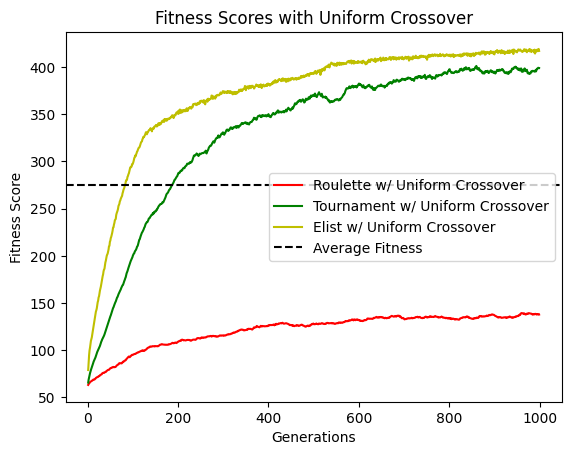

In [38]:
avg_fitness = [sum(scores)/len(scores) for scores in zip(g1,g4,g7)]
avg_fitness_mean = sum(avg_fitness) / len(avg_fitness)

plt.plot(ind, g1, label='Roulette w/ Uniform Crossover', color='r')
plt.plot(ind, g4, label='Tournament w/ Uniform Crossover', color='g')
plt.plot(ind, g7, label='Elist w/ Uniform Crossover', color='y')

plt.axhline(y=avg_fitness_mean, color='black', linestyle='--', label='Average Fitness')
plt.legend()
plt.title("Fitness Scores with Uniform Crossover")
plt.xlabel("Generations")
plt.ylabel("Fitness Score")
plt.show()

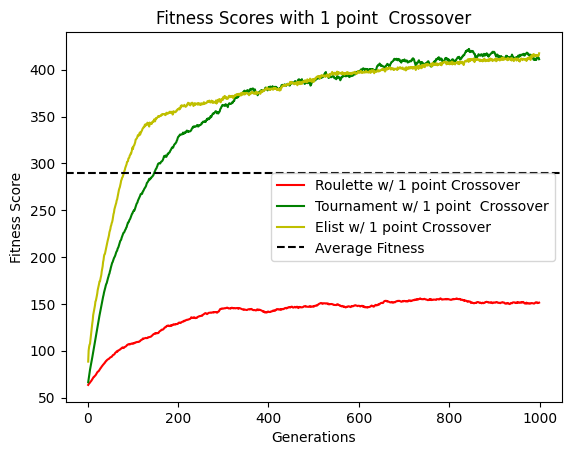

In [39]:
avg_fitness = [sum(scores)/len(scores) for scores in zip(g2,g5,g8)]
avg_fitness_mean = sum(avg_fitness) / len(avg_fitness)

plt.plot(ind, g2, label='Roulette w/ 1 point Crossover', color='r')
plt.plot(ind, g5, label='Tournament w/ 1 point  Crossover', color='g')
plt.plot(ind, g8, label='Elist w/ 1 point Crossover', color='y')

plt.axhline(y=avg_fitness_mean, color='black', linestyle='--', label='Average Fitness')
plt.legend()
plt.title("Fitness Scores with 1 point  Crossover")
plt.xlabel("Generations")
plt.ylabel("Fitness Score")
plt.show()

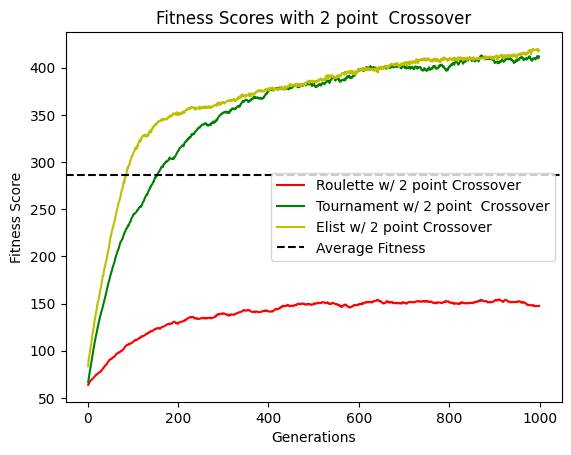

In [40]:
avg_fitness = [sum(scores)/len(scores) for scores in zip(g3,g6,g9)]
avg_fitness_mean = sum(avg_fitness) / len(avg_fitness)

plt.plot(ind, g3, label='Roulette w/ 2 point Crossover', color='r')
plt.plot(ind, g6, label='Tournament w/ 2 point  Crossover', color='g')
plt.plot(ind, g9, label='Elist w/ 2 point Crossover', color='y')

plt.axhline(y=avg_fitness_mean, color='black', linestyle='--', label='Average Fitness')
plt.legend()
plt.title("Fitness Scores with 2 point  Crossover")
plt.xlabel("Generations")
plt.ylabel("Fitness Score")
plt.show()

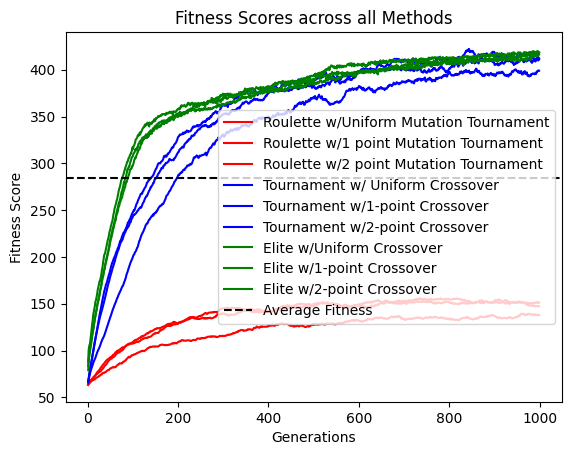

In [51]:
avg_fitness = [sum(scores)/len(scores) for scores in zip(g1, g2, g3, g4, g5, g6 ,g7, g8, g9)]
avg_fitness_mean = sum(avg_fitness) / len(avg_fitness)

plt.plot(ind, g1, label='Roulette w/Uniform Mutation Tournament', color='red')
plt.plot(ind, g2, label='Roulette w/1 point Mutation Tournament', color='red')
plt.plot(ind, g3, label='Roulette w/2 point Mutation Tournament', color='red')
plt.plot(ind, g4, label='Tournament w/ Uniform Crossover', color='blue')
plt.plot(ind, g5, label='Tournament w/1-point Crossover', color='blue')
plt.plot(ind, g6, label='Tournament w/2-point Crossover', color='blue')
plt.plot(ind, g7, label='Elite w/Uniform Crossover', color='green')
plt.plot(ind, g8, label='Elite w/1-point Crossover', color='green')
plt.plot(ind, g9, label='Elite w/2-point Crossover', color='green')
plt.axhline(y=avg_fitness_mean, color='black', linestyle='--', label='Average Fitness')
plt.legend()
plt.title("Fitness Scores across all Methods")
plt.xlabel("Generations")
plt.ylabel("Fitness Score")
plt.show()

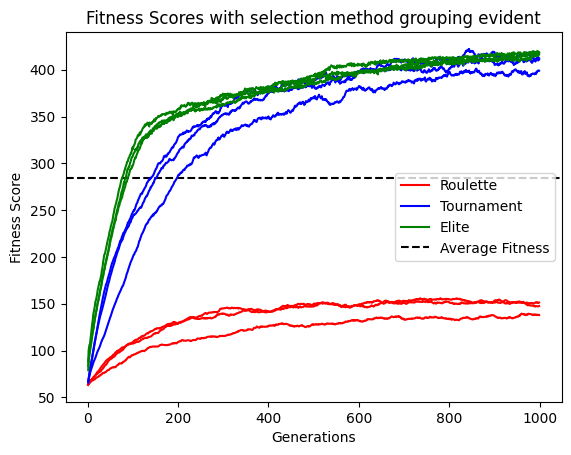

In [56]:
legend_dict = {'Roulette': 'red', 'Tournament': 'blue', 'Elite': 'green'}
for label, color in legend_dict.items():
    plt.plot([], [], color=color, label=label)
plt.axhline(y=avg_fitness_mean, color='black', linestyle='--', label='Average Fitness')
plt.plot(ind, g1, color=legend_dict['Roulette'])
plt.plot(ind, g2, color=legend_dict['Roulette'])
plt.plot(ind, g3, color=legend_dict['Roulette'])
plt.plot(ind, g4, color=legend_dict['Tournament'])
plt.plot(ind, g5, color=legend_dict['Tournament'])
plt.plot(ind, g6, color=legend_dict['Tournament'])
plt.plot(ind, g7, color=legend_dict['Elite'])
plt.plot(ind, g8, color=legend_dict['Elite'])
plt.plot(ind, g9, color=legend_dict['Elite'])
plt.legend()#loc='upper left')
plt.title("Fitness Scores with selection method grouping evident")
plt.xlabel("Generations")
plt.ylabel("Fitness Score")
plt.show()

In [91]:
avg_mutation = [sum(scores)/len(scores) for scores in zip(mutations1, mutations2,mutations3, mutations4, mutations5,
                                                         mutations6)]
avg_mutation_mean = sum(avg_mutation) / len(avg_mutation)
avg_mutation_mean

3.0199057064632626

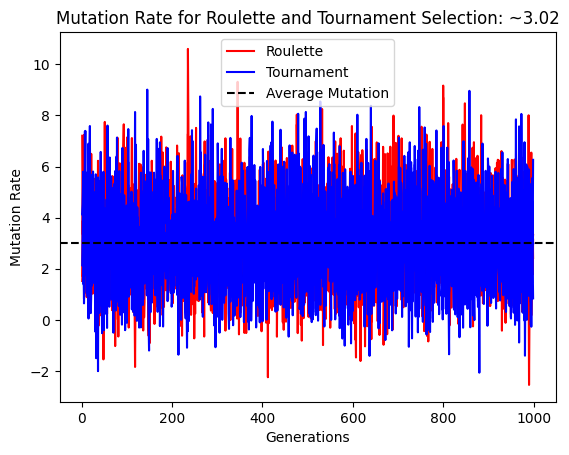

In [93]:
legend_dict = {'Roulette': 'red', 'Tournament': 'blue'}
for label, color in legend_dict.items():
    plt.plot([], [], color=color, label=label)
plt.plot(ind, mutations1, color=legend_dict['Roulette'])
plt.plot(ind, mutations2, color=legend_dict['Roulette'])
plt.plot(ind, mutations3, color=legend_dict['Roulette'])
plt.plot(ind, mutations4, color=legend_dict['Tournament'])
plt.plot(ind, mutations5, color=legend_dict['Tournament'])
plt.plot(ind, mutations6, color=legend_dict['Tournament'])
plt.axhline(y=avg_mutation_mean, color='black', linestyle='--', label='Average Mutation')
plt.legend()
plt.title("Mutation Rate for Roulette and Tournament Selection: ~3.02")
plt.xlabel("Generations")
plt.ylabel("Mutation Rate")
plt.show()

3.0504831254097735


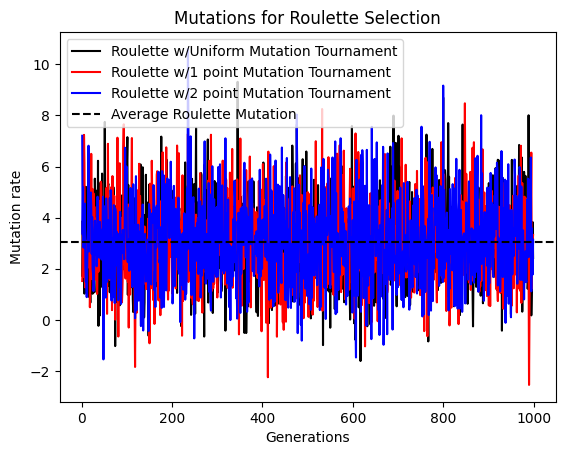

In [82]:
avg_mutation = [sum(scores)/len(scores) for scores in zip(mutations1, mutations2,mutations3)]
avg_mutation_mean = sum(avg_mutation) / len(avg_mutation)
print(avg_mutation_mean)
plt.plot(ind, mutations1, label='Roulette w/Uniform Mutation Tournament', color='black')
plt.plot(ind, mutations2, label='Roulette w/1 point Mutation Tournament', color='red')
plt.plot(ind, mutations3, label='Roulette w/2 point Mutation Tournament', color='blue')
plt.axhline(y=avg_mutation_mean, color='black', linestyle='--', label='Average Roulette Mutation')
plt.legend()
plt.title("Mutations for Roulette Selection")
plt.xlabel("Generations")
plt.ylabel("Mutation rate")
plt.show()

2.9893282875167557


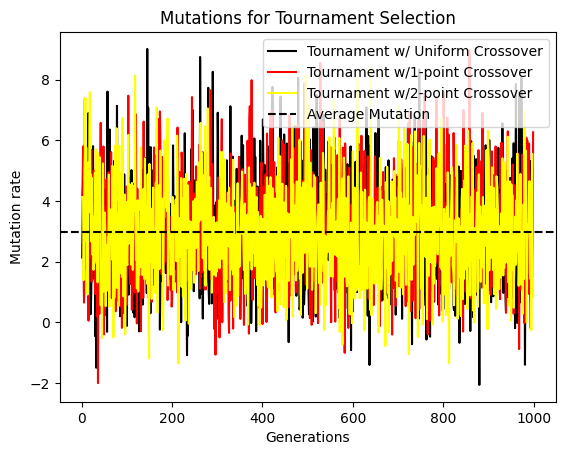

In [83]:
avg_mutation = [sum(scores)/len(scores) for scores in zip(mutations4, mutations5,mutations6)]
avg_mutation_mean = sum(avg_mutation) / len(avg_mutation)
print(avg_mutation_mean)
plt.plot(ind, mutations4, label='Tournament w/ Uniform Crossover', color='black')
plt.plot(ind, mutations5, label='Tournament w/1-point Crossover', color='red')
plt.plot(ind, mutations6, label='Tournament w/2-point Crossover', color='yellow')

plt.axhline(y=avg_mutation_mean, color='black', linestyle='--', label='Average Mutation')
plt.legend()
plt.title("Mutations for Tournament Selection")
plt.xlabel("Generations")
plt.ylabel("Mutation rate")
plt.show()

0.297311456813938


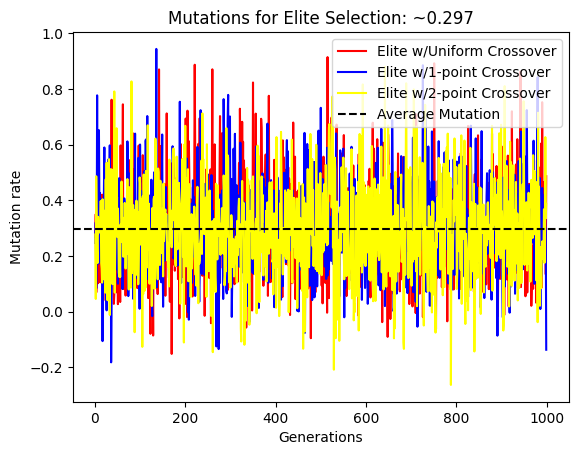

In [94]:
avg_mutation = [sum(scores)/len(scores) for scores in zip(mutations7, mutations8,mutations9)]
avg_mutation_mean = sum(avg_mutation) / len(avg_mutation)
print(avg_mutation_mean)
plt.plot(ind, mutations7, label='Elite w/Uniform Crossover', color='red')
plt.plot(ind, mutations8, label='Elite w/1-point Crossover', color='blue')
plt.plot(ind, mutations9, label='Elite w/2-point Crossover', color='yellow')
plt.axhline(y=avg_mutation_mean, color='black', linestyle='--', label='Average Mutation')
plt.legend()
plt.title("Mutations for Elite Selection: ~0.297")
plt.xlabel("Generations")
plt.ylabel("Mutation rate")
plt.show()

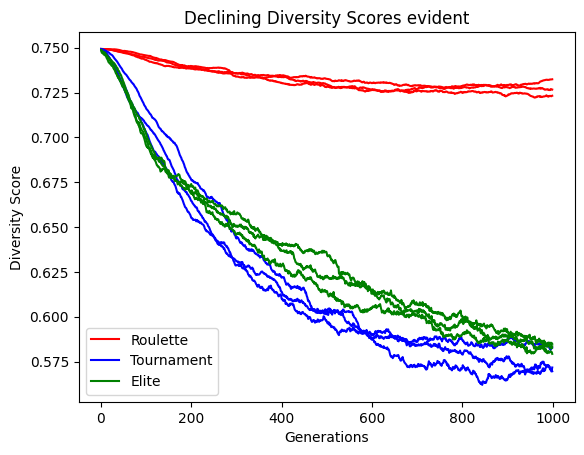

In [97]:
legend_dict = {'Roulette': 'red', 'Tournament': 'blue', 'Elite': 'green'}
for label, color in legend_dict.items():
    plt.plot([], [], color=color, label=label)
#plt.axhline(y=avg_fitness_mean, color='black', linestyle='--', label='Average Fitness')
plt.plot(ind, d1, color=legend_dict['Roulette'])
plt.plot(ind, d2, color=legend_dict['Roulette'])
plt.plot(ind, d3, color=legend_dict['Roulette'])
plt.plot(ind, d4, color=legend_dict['Tournament'])
plt.plot(ind, d5, color=legend_dict['Tournament'])
plt.plot(ind, d6, color=legend_dict['Tournament'])
plt.plot(ind, d7, color=legend_dict['Elite'])
plt.plot(ind, d8, color=legend_dict['Elite'])
plt.plot(ind, d9, color=legend_dict['Elite'])
plt.legend()#loc='upper left')
plt.title("Declining Diversity Scores evident")
plt.xlabel("Generations")
plt.ylabel("Diversity Score")
plt.show()

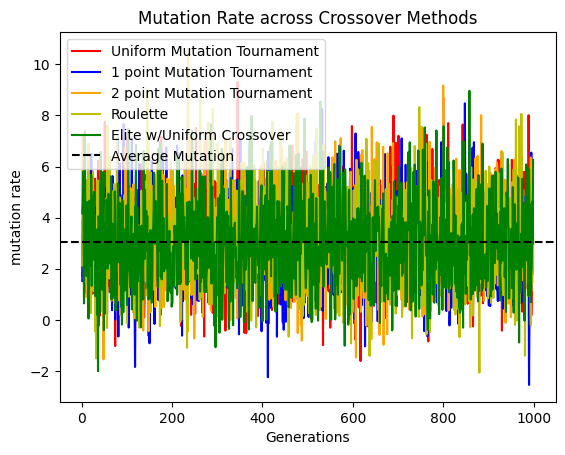

In [98]:
avg_mute = [sum(scores)/len(scores) for scores in zip(mutations1, mutations2,mutations3, mutations4, mutations5)]
avg_mute_mean = sum(avg_mute) / len(avg_mute)

plt.plot(ind, mutations1, label='Uniform Mutation Tournament', color='r')
plt.plot(ind, mutations2, label='1 point Mutation Tournament', color='b')
plt.plot(ind, mutations3, label='2 point Mutation Tournament', color='orange')
plt.plot(ind, mutations4, label='Roulette', color='y')
plt.plot(ind, mutations5, label='Elite w/Uniform Crossover', color='g')
plt.axhline(y=avg_mute_mean, color='black', linestyle='--', label='Average Mutation')
plt.legend()
plt.title("Mutation Rate across Crossover Methods")
plt.xlabel("Generations")
plt.ylabel("mutation rate")
plt.show()

In [16]:
methods = ['Roulette Uniform crossover','Roulette 1-point crossover','Roulette 2-point crossover',
           'Tournament Uniform crossover','Tournament 1-point crossover','Tournament 2-point crossover',
           'Elite Uniform crossover','Elite 1-point crossover','Elite 2-point crossover']

df = pd.DataFrame(list(zip(methods, 
                           ave_mutations,
                           max_mutations, 
                           ave_scores,
                           ave_diversity, 
                           max_scores,
                           times, 
                           max_iterations)), 

columns = ['Method', 'ave mutations','max mutations','ave score','ave diversity','max score','Time (sec)', 'Max @ Iter'])
df.style.set_caption('All the data')
df.style.set_table_styles([{'selector': 'th', 'props': [('border-bottom', '1px solid black')]}])
#df.to_pickle("assignment1")
display(df)

,Method,ave mutations,max mutations,ave score,ave diversity,max score,Time (sec),Max @ Iter
0,Roulette Uniform crossover,3.135386,10.552784,119.507162,0.732138,136.710,1740.068649,626
1,Roulette 1-point crossover,3.059377,10.552784,140.290757,0.732599,160.531,1449.754749,893
2,Roulette 2-point crossover,2.957023,9.681600,137.616544,0.735196,155.327,1419.237843,921
3,Tournament Uniform crossover,2.961795,9.380843,329.287962,0.633117,390.927,1625.144693,956
4,Tournament 1-point crossover,2.931920,9.556901,363.832165,0.619426,420.537,1332.552378,851
5,Tournament 2-point crossover,2.975921,9.256429,351.717123,0.627980,409.830,1292.317592,938
6,Elite Uniform crossover,0.298273,0.888121,368.687200,0.637603,422.657,1643.691180,977
7,Elite 1-point crossover,0.298344,1.157976,380.192348,0.625168,430.000,1352.014489,984
8,Elite 2-point crossover,0.302159,0.913203,369.369477,0.635221,425.000,1353.799133,961


In [17]:
methods = ['Roulette Uniform crossover','Roulette 1-point crossover','Roulette 2-point crossover',
           'Tournament Uniform crossover','Tournament 1-point crossover','Tournament 2-point crossover',
           'Elite Uniform crossover','Elite 1-point crossover','Elite 2-point crossover']

df2 = pd.DataFrame(list(zip(methods, 
                           ave_mutations, 
                           ave_scores,
                           ave_diversity, 
                           times, 
                           max_iterations)), 

columns = ['Method', 'ave mutations','ave score','ave diversity','Time (sec)', 'Max @ Iter'])
df2.style.set_caption('All the data')
df2.style.set_table_styles([{'selector': 'th', 'props': [('border-bottom', '1px solid black')]}])
#df2.to_pickle("assignment1_small")
display(df2)


,Method,ave mutations,ave score,ave diversity,Time (sec),Max @ Iter
0,Roulette Uniform crossover,3.135386,119.507162,0.732138,1740.068649,626
1,Roulette 1-point crossover,3.059377,140.290757,0.732599,1449.754749,893
2,Roulette 2-point crossover,2.957023,137.616544,0.735196,1419.237843,921
3,Tournament Uniform crossover,2.961795,329.287962,0.633117,1625.144693,956
4,Tournament 1-point crossover,2.931920,363.832165,0.619426,1332.552378,851
5,Tournament 2-point crossover,2.975921,351.717123,0.627980,1292.317592,938
6,Elite Uniform crossover,0.298273,368.687200,0.637603,1643.691180,977
7,Elite 1-point crossover,0.298344,380.192348,0.625168,1352.014489,984
8,Elite 2-point crossover,0.302159,369.369477,0.635221,1353.799133,961


In [4]:
summary = pd.read_pickle("assignment1")
console = Console()
style = "bold blue"
table = Table('Summary for all experimental evolutionary simulations')
table.add_row(summary.to_string(float_format=lambda _: '{:.2f}'.format(_)))
#console.print(table,style = style)

In [11]:
#summary['Time (min)'] = summary['Time (sec)']/60
summary['rating'] = summary['ave diversity']*summary['ave score']

In [12]:
summary.columns

Index(['Method', 'ave mutations', 'max mutations', 'ave score',
       'ave diversity', 'max score', 'Time (sec)', 'Max @ Iter', 'Time (min)',
       'rating'],
      dtype='object')

In [15]:
table2 = summary[['Method','Time (min)','ave mutations','ave score','ave diversity','rating']]

In [16]:
table2.to_pickle("table2")

In [18]:
summary = pd.read_pickle("table2")
console = Console()
style = "bold blue"
table = Table('Summary for all experimental evolutionary simulations')
table.add_row(summary.to_string(float_format=lambda _: '{:.2f}'.format(_)))
console.print(table)#,style = style)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Summary for all experimental evolutionary simulations                                        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                          Method  Time (min)  ave mutations  ave score  ave diversity  rating │
│ 0    Roulette Uniform crossover       29.00           3.14     119.51           0.73   87.50 │
│ 1    Roulette 1-point crossover       24.16           3.06     140.29           0.73  102.78 │
│ 2    Roulette 2-point crossover       23.65           2.96     137.62           0.74  101.18 │
│ 3  Tournament Uniform crossover       27.09           2.96     329.29           0.63  208.48 │
│ 4  Tournament 1-point crossover       22.21           2.93     363.83           0.62  225.37 │
│ 5  Tournament 2-point crossover       21.54           2.98     351.72           0.63  220.87 │
│ 6       Elite Uniform crossover       27.39           0.30     368.69           0.64  235.08 │
│ 7       Elite 1-point crossover       22.53           0.30     380.19           0.63  237.68 │
│ 8       Elite 2-point crossover       22.56           0.30     369.37           0.64  234.63 │
└──────────────────────────────────────────────────────────────────────────────────────────────┘

In [100]:
pyg.walk(summary)

<IPython.core.display.Javascript object>

# Experiment 2:  alignment 

In [ ]:
genomesize = 10

In [ ]:
    

def calculate_diversity(genome):
        n = genomesize
        counts = {}
        for letter in genome:
            counts[letter] = counts.get(letter, 0) + 1
        freqs = [count/n for count in counts.values()]
        diversity = sum([(f*(1-f)) for f in freqs])
        return diversity

In [ ]:
p1 = population()
print(calculate_diversity(p1.the_pop[0].genome))
print(p1.the_pop[0].fitness)
print(calculate_diversity(p1.the_pop[3].genome))
print(p1.the_pop[1].fitness)

In [ ]:
def printmatrix(m,pad = 4): 
    for r in m:
        for d in r:
            print(f"{str(d):>{pad}}", end = " ")
        print()

In [ ]:
seq1 = p.the_pop[1].genome
seq2 = p.the_pop[2].genome
seq2

In [ ]:

gappenalty = -8
scoringmatrix = [[00 for i in range(0,len(seq1)+1)] for j in range(0,len(seq2)+1)]
directionmatrix = [["." for i in range(0,len(seq1)+1)] for j in range(0,len(seq2)+1)]
#print(scoringmatrix)
#scoringmatrix[0][1] = 77
#print(scoringmatrix)
#printmatrix(scoringmatrix)

In [ ]:
for i in range(0,len(scoringmatrix[0])):
    scoringmatrix[0][i] =  i*gappenalty
    directionmatrix[0][i] = "h "
for i in range(0,len(scoringmatrix)):
    scoringmatrix[i][0] = i*gappenalty
    directionmatrix[i][0]  = "v "

for r in range(1,len(scoringmatrix)):
    for c in range(1,len(scoringmatrix[r])):
        vert = scoringmatrix[r-1][c] + gappenalty
        horz = scoringmatrix[r][c-1] + gappenalty
        diag = scoringmatrix[r-1][c-1]
        if(seq1[c-1] == seq2[r-1]):
            diag += 10
        else:
            diag -= 10
        scoringmatrix[r][c] = max(vert,horz,diag)
        #directionmatrix[r][c] = "v or h or d"
        if diag >= horz and diag >= vert:
            directionmatrix[r][c] = "\u2196"
        if horz > diag and horz > vert:
            directionmatrix[r][c] = "\u2190"
        if vert > diag and vert > horz:
            directionmatrix[r][c] = "\u2191"

In [ ]:
printmatrix(scoringmatrix)

In [ ]:
printmatrix(directionmatrix)

In [ ]:
times,sizes,ave_scores,max_scores,max_iterations,ave_mutations,max_mutations,ave_diversity,max_diversity

g1,g2,g3,g4,g5,g6,g7,g8,g9
d1,d2,d3,d4,d5,d6,d7,d8,d9
mutations1,mutations2,mutations3,mutations4,mutations5,mutations6,mutations7,mutations8,mutations9

In [ ]:
methods = ['Roulette Uniform crossover','Roulette 1-point crossover','Roulette 2-point crossover',
           'Tournament Uniform crossover','Tournament 1-point crossover','Tournament 2-point crossover',
           'Elite Uniform crossover','Elite 1-point crossover','Elite 2-point crossover']

df = pd.DataFrame(list(zip(methods, 
                           ave_mutations,
                           max_mutations, 
                           ave_scores,
                           ave_diversity, 
                           max_scores,
                           times, 
                           max_iterations)), 

columns = ['Method', 'ave mutations','max mutations','ave score','ave diversity','max score','Time (sec)', 'Max @ Iter'])
df.style.set_caption('All the data')
df.style.set_table_styles([{'selector': 'th', 'props': [('border-bottom', '1px solid black')]}])